In [1]:
import networkx as nx
import matplotlib.pyplot as plt 
from IPython.display import SVG, display
import pygraphviz
# Note: to install pygraphviz on macOS, you need to first install graphviz using homebrew,
# and then tell pip to look for the graphviz headers and libraries in the homebrew directory:
#  brew install graphviz
#  python3 -m pip install \
#                --config-settings="--global-option=build_ext" \
#                --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
#                --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
#                pygraphviz

# TODO: move the SVG rendering to a git pre-commit hook so that people can change DOT files directly without needing
# to run this script to see the changes.

# README

In [2]:
class BlockGraph:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.graph.add_node('source', label='start')
        self.graph.add_node('sink', label='end')
        self.source_node = 'source'
        self.sink_node = 'sink'

    def add_node(self, sequence, node_id=None):
        """
        Adds a node to the graph.

        Parameters:
        sequence (str): The sequence associated with a node. Note that in the actual gen code the sequence is hashed to save space.
        """
        if node_id is None:
            # Start node IDs at 1, not counting source and sink
            node_id = self.graph.number_of_nodes() - 1 

        self.graph.add_node(node_id, sequence=sequence)
        return node_id
    
    def connect_to_source(self, node_id, to_pos=0):
        """
        Connects a node to the source node.

        Parameters:
        node_id (int): The ID of the node to connect to the source.
        to_pos (int): The position at which the edge arrives at node.
        """
        self.graph.add_edge(self.source_node, node_id, to_pos=to_pos, rank='same', constraint=False)

    def connect_to_sink(self, node_id, from_pos=-1):
        """
        Connects a node to the sink node.

        Parameters:
        node_id (int): The ID of the node to connect to the sink.
        from_pos (int): The position from which the edge departs from the node.
        """
        if from_pos == -1:
            from_pos = len(self.graph.nodes[node_id]['sequence'])-1
            
        self.graph.add_edge(node_id, self.sink_node, from_pos=from_pos, rank='same', constraint=False)

    def add_edge(self, source, target):
        """
        Adds an edge to the graph with port information stored as edge attributes.

        Parameters:
        source (tuple): A tuple containing the source node and the position from which the edge departs.
        target (tuple): A tuple containing the target node and the position at which the edge arrives.
        """
        self.graph.add_edge(source[0], target[0], from_pos=source[1], to_pos=target[1])

    def import_from_db(self, db):
        """
        Imports a graph from a gen database.

        Parameters:
        db (Database): The gen sqlite3 .db file to import the graph from.
        """
        con = sqlite3.connect(db_file)
        cur = con.cursor()
        cur.execute('''SELECT id, sequence
        FROM nodes
        JOIN sequences
        ON nodes.sequence_hash = sequences.hash 
        ''')
        nodes = cur.fetchall()

        source_node, sink_node = None, None
        for id, sequence in nodes:
            if sequence.startswith('start-'):
                source_node = id
                continue
            if sequence.startswith('end-'):
                sink_node = id
                continue

            self.add_node(sequence, node_id=id)


        cur.execute('SELECT id, source_node_id, source_coordinate, target_node_id, target_coordinate from edges')
        edges = cur.fetchall()

        # In the Rust code, from_pos is considered to be exclusive to the range of the block, 
        # so we need to subtract 1 to get the conventional position in the sequence.
        for id, source, from_pos, target, to_pos in edges:
            if source == source_node or from_pos == 0:
                self.connect_to_source(target, to_pos)
            elif target == sink_node:
                self.connect_to_sink(source, from_pos-1)
            else:
                self.add_edge((source, from_pos-1), (target, to_pos))
    
    def make_segment_graph(self):
        # Split up all nodes into segments (i.e. contiguous subsequences)
        segment_graph = nx.DiGraph()

        # Add source and sink nodes
        segment_graph.add_node('source', label='start', original_node='source', end=-1)
        segment_graph.add_node('sink', label='end', original_node='sink', start=0)

        # Iterate over the nodes in the graph and split them into segments
        for node in self.graph.nodes:
            if node in ['source', 'sink']:
                continue

            # Get ports from incoming and outgoing edges
            in_ports = [data.get('to_pos',0) for source, target, data in self.graph.in_edges(node, data=True)]
            out_ports = [data.get('from_pos',-1) for source, target, data in self.graph.out_edges(node, data=True)]

            sequence = self.graph.nodes[node].get('sequence', None)
            highlights = self.graph.nodes[node].get('highlights', [False] * len(sequence))

            # New segments are defined by the port node identifier, and a start and end position on the sequence the port node references.
            # Each "in port" needs to be present as a segment start, and each "out port" as a segment end.
            # All in ports are preceded by a segment end, an all out ports are followed by a segment start.
            # Position 0 and the last position are always segment starts and ends, respectively.
            starts = sorted(set([0] + in_ports + [x+1 for x in out_ports if x < (len(sequence)-1)]))
            ends = sorted(set(out_ports + [len(sequence)-1] + [x-1 for x in in_ports if x > 0])) 

            # Create the segments
            segments = []
            for i, j in zip(starts, ends):
                segment_id = f"{node}.{i}"
                segment_graph.add_node(segment_id, 
                                       sequence = sequence[i:j+1], 
                                       highlights = highlights[i:j+1],
                                       original_node = node, 
                                       start=i, end=j)
                segments.append(segment_id)

            # Create new edges between the segments to represent the reference sequence
            for i, j in zip(segments[:-1], segments[1:]):
                segment_graph.add_edge(i, j, reference=True)

        # Translate the original edges to new edges in the segment graph
        for source, target, port_data in self.graph.edges(data=True):
            source_end = port_data.get('from_pos', -1)
            target_start = port_data.get('to_pos', 0)
            
            # Find the segments that correspond to the source and target nodes, there should be only one of each
            source_segments = [node for node, segment_data in segment_graph.nodes(data=True) if segment_data['original_node'] == source and segment_data['end'] == source_end]
            target_segments = [node for node, segment_data in segment_graph.nodes(data=True) if segment_data['original_node'] == target and segment_data['start'] == target_start]
            assert len(source_segments) == 1
            assert len(target_segments) == 1

            segment_graph.add_edge(source_segments[0], target_segments[0], reference=False)

        return segment_graph

    def highlight_ranges(self, node_id, highlight_ranges):
        """
        Highlights specific ranges in a node's sequence.

        Parameters:
        node_id (int): The ID of the node to apply highlights to.
        highlight_ranges (list): A list of tuples containing the start and end positions of the ranges to highlight.
        """
        sequence = self.graph.nodes[node_id]['sequence']
        highlights = [False] * len(sequence)
        for start, end in highlight_ranges:
            for i in range(start, end):
                highlights[i] = True
        self.graph.nodes[node_id]['highlights'] = highlights

    def render_graph(self, filename=None, minimize=False, splines=True, hide_nodes=[]):
        # Create a copy of the graph to avoid modifying the original
        graph = self.graph.copy()
        # Remove nodes that are marked as hidden
        for node in hide_nodes:
            graph.remove_node(node)

        rankdir = 'TD' # Top to bottom works best for the unsegmented graph

        for node in graph.nodes:
            if node in ['source', 'sink']:
                continue
            sequence = graph.nodes[node]['sequence']
            highlights = graph.nodes[node].get('highlights', [False] * len(sequence))
            formatted_sequence = [f'<B>{c}</B>' if highlights[i] else c for i, c in enumerate(sequence)]

            if minimize:
                label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0' CELLPADDING='5'><TR>"
                label += f"<TD BORDER='0' PORT='caption'>{node}: </TD>"
                # Only show the ports that are connected to other nodes
                connected_ports = set()
                for edge in graph.in_edges(node):
                    connected_ports.add(graph.edges[edge]['to_pos'])
                for edge in graph.out_edges(node):
                    connected_ports.add(graph.edges[edge]['from_pos'])
                connected_ports = sorted(connected_ports)
                # Start of a list that contains each port of the node, with ellipses between ports that are not sequential
                labeled_sequence = [f"<TD PORT='{connected_ports[0]}'><FONT FACE='Courier New'>{formatted_sequence[connected_ports[0]]}<SUB>{connected_ports[0]}</SUB></FONT></TD>"]
                if len(connected_ports) > 1 and (connected_ports[1]-connected_ports[0]) > 1:
                    labeled_sequence.append("<TD>...</TD>")
                # Loop over the connected ports in pairs of two, so that we can take into account the gaps between them.
                for a, b in zip(connected_ports, connected_ports[1:]):
                    labeled_sequence.append(f"<TD PORT='{b}'><FONT FACE='Courier New'>{formatted_sequence[b]}<SUB>{b}</SUB></FONT></TD>")
                    if b - a > 1 and b != connected_ports[-1]:
                        labeled_sequence.append("<TD>...</TD>")
                label += '\n'.join(labeled_sequence)
                label += "</TR></TABLE>>"
                
            else:
                label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0'><TR>"
                label += f"<TD BORDER='0' PORT='caption'>{node}: </TD>"
                labeled_sequence = [f"<TD PORT='{i}'><FONT FACE='Courier New'>{c}</FONT></TD>" 
                                      for i, c in enumerate(formatted_sequence)]
                label += '\n'.join(labeled_sequence)
                label += "</TR></TABLE>>"

            graph.nodes[node]['shape'] = 'none'
            graph.nodes[node]['margin'] = 0
            graph.nodes[node]['label'] = label

        for edge in graph.edges:
            # Connect the head and tail of each edge to the correct port
            graph.edges[edge]['headport'] = f"{graph.edges[edge].get('to_pos','w')}"
            graph.edges[edge]['tailport'] = f"{graph.edges[edge].get('from_pos','e')}"
            # Cleaner look for the first edge coming out of the source node:
            if edge[0] == 'source' and graph.edges[edge]['headport'] == '0':
                graph.edges[edge]['headport'] = 'caption'
            # If the full graph is layed out from left to right, do the same for all nodes:
            if rankdir == 'LR' and graph.edges[edge]['headport'] == '0':
                graph.edges[edge]['headport'] = 'caption'

        # Convert the networkx graph to a pygraphviz graph
        graph = nx.nx_agraph.to_agraph(graph)

        # Draw the graph using pygraphviz
        graph.layout(prog='dot', args=f"-Grankdir={rankdir} -Gsplines={'true' if splines else 'false'}")
        if filename:
            graph.write(f'{filename}.dot')
            graph.draw(f'{filename}.svg', prog='dot', format='svg')
            
        display(SVG(graph.draw(prog='dot', format='svg')))

    def render_segment_graph(self, filename=None, minimize=False, splines = True, hide_nodes=[]):
        graph = self.make_segment_graph()
        # Mark all internal edges with a dashed line
        for edge in graph.edges:
            if graph.edges[edge].get('reference', False):
                graph.edges[edge]['style'] = 'dashed'
        rankdir = 'LR'

        for node in hide_nodes:
            graph.remove_node(node)

        for node in graph.nodes:
            if node in ['source', 'sink']:
                continue
            sequence = graph.nodes[node]['sequence']
            highlights = graph.nodes[node].get('highlights', [False] * len(sequence))
            formatted_sequence = [f'<B>{c}</B>' if highlights[i] else c for i, c in enumerate(sequence)]
            origin = graph.nodes[node]['original_node']
            start = graph.nodes[node].get('start', 0)
            end = graph.nodes[node].get('end', len(sequence)-1)

            if minimize and len(sequence) > 3:
                # Only show the first and last element of each segment, with coordinates
                label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0'><TR>"
                label += f"<TD BORDER='0' PORT='caption'>{origin}.{start}:&nbsp;</TD>"
                # TODO: find a cleaner way to get the start and end coordinate included
                label += f"<TD><FONT FACE='Courier New'>{formatted_sequence[0]}&nbsp;…&nbsp;{formatted_sequence[-1]}</FONT></TD>"
                label += "</TR></TABLE>>"  
            else:
                label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0'><TR>"
                label += f"<TD BORDER='0' PORT='caption'>{origin}.{start}:&nbsp;</TD>" 
                label += f"<TD><FONT FACE='Courier New'>{''.join(formatted_sequence)}</FONT></TD>"
                label += "</TR></TABLE>>"

            graph.nodes[node]['shape'] = 'none'
            graph.nodes[node]['margin'] = 0
            graph.nodes[node]['label'] = label

        for edge in graph.edges:
            graph.edges[edge]['headport'] = 'caption'
            graph.edges[edge]['tailport'] = 'e'

        # Convert the networkx graph to a pygraphviz graph
        graph = nx.nx_agraph.to_agraph(graph)

        # Draw the graph using pygraphviz
        graph.layout(prog='dot', args=f"-Grankdir={rankdir} -Gsplines={'true' if splines else 'false'}")
        if filename:
            graph.write(f'{filename}.dot')
            graph.draw(f'{filename}.svg', prog='dot', format='svg')
            
        display(SVG(graph.draw(prog='dot', format='svg')))



## Figure 1

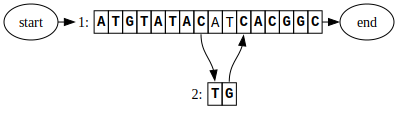

In [3]:
G = BlockGraph()

n1 = G.add_node('ATGTATACATCACGGC') # Derived from BBa_K1896001
n2 = G.add_node('TG')
G.connect_to_source(n1)
G.connect_to_sink(n1)
G.add_edge((n1, 7), (n2, 0))
G.add_edge((n2, 1), (n1, 10))
G.highlight_ranges(n1, [(0, 8), (10, 16)])
G.highlight_ranges(n1, [(0, 8), (10, 16)])
G.highlight_ranges(n2, [(0, 2)])

G.render_graph('figure_1', minimize=False)

## Figure 2

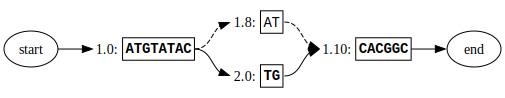

In [4]:
G.render_segment_graph('figure_2', minimize=False)

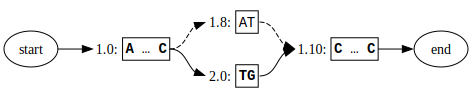

In [5]:
G.render_segment_graph('figure_2_minimized', minimize=True)

# Examples

## Protein Engineering

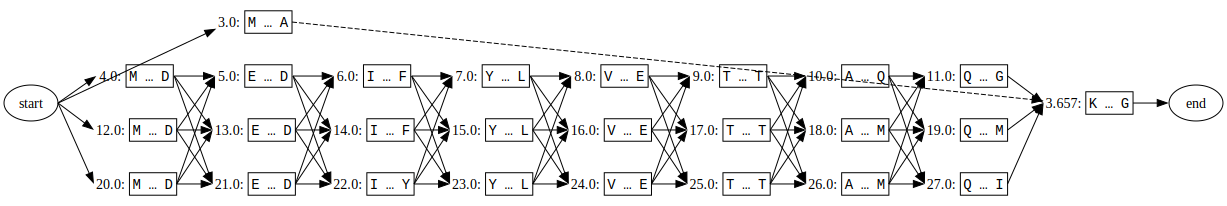

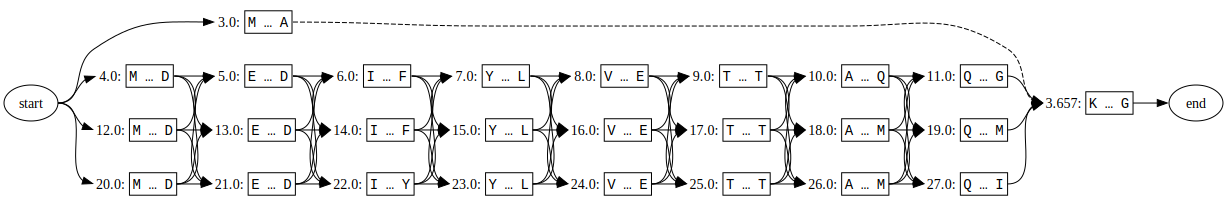

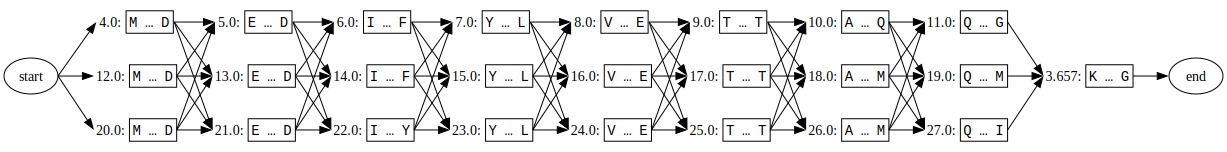

In [ ]:
import sqlite3

db_file = '../../examples/protein_engineering/test.db'

G = BlockGraph()
G.import_from_db(db_file)
G.render_segment_graph(minimize=True, splines=False)
G.render_segment_graph(minimize=True, splines=True)

G.render_segment_graph('protein_figure_1', minimize=True, splines=False, hide_nodes=['3.0'])


